In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps

import scipy

In [3]:
# ---------- FUNCTIONS ---------- #

#___SCALING___#
def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

#___LOWPASS FILTER___#
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

#___DOWNSAMPLING___#
def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


#___STATS___#

def segment_data(data, num_segments):
    # data: numpy array of shape (records, sensors, timepoints)
    num_sensors, num_timepoints = data.shape
    segment_length = num_timepoints // num_segments

    # Initialize array for segmented data
    # Shape: (records, sensors, segments, segment_length)
    segmented_data = np.zeros((num_sensors, num_segments, segment_length))

    for sensor in range(num_sensors):
        for segment in range(num_segments):
            start = segment * segment_length
            end = start + segment_length
            segmented_data[sensor, segment] = data[sensor, start:end]

    return segmented_data



In [4]:
# LOAD FILES

def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [5]:
############################################################################
# ------------------------------ Train Data ------------------------------ #
############################################################################

In [5]:
# Call Preprocessing functions
def preprocess_data(data, i, segments):
  print(f"*** FILE {i} ***")
  data = apply_scaling(data)
  print("scaling applied: shape:", data.shape, end=', ')
  data = apply_lowpass(data)
  print("lowpass applied: shape:", data.shape, end=', ')
  data = apply_downsampling(data)
  print("downsam applied: shape:", data.shape, end=', ')
  data = segment_data(data,segments)
  print("Data after segmentation:", np.array(data).shape)
  return np.array(data)


In [6]:
# Retieve the initial data from the folder

fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)

meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

fmri_data_folder: /content/drive/.shortcut-targets-by-id/12woTG1TRZVOuuOVm6KXBkIIxROFpmg72/meg_data/Intra/train


In [7]:
print("## Initial shapes of the data ##")
print("MEG:", meg_train_data_array.shape)
print("Labels:",labels_train_array.shape)

## Initial shapes of the data ##
MEG: (32, 248, 35624)
Labels: (32,)


In [8]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #
segments = 61
processed_data = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], segments, meg_train_data_array.shape[2]//(4*segments)))
print(processed_data.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_train_data_array[i], i+1, segments)

(32, 248, 61, 146)
*** FILE 1 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 2 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 3 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 4 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 5 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 6 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after se

In [9]:
X_train = processed_data
y_train = to_categorical(labels_train_array, num_classes=4)

del processed_data, labels_train_array

In [10]:
print("## Final shapes of the data ##")
print("MEG:", X_train.shape)
print("Labels:",y_train.shape)

## Final shapes of the data ##
MEG: (32, 248, 61, 146)
Labels: (32, 4)


In [11]:
# ----- MODEL ----- #

def build_dnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# ----- TRAINING THE DNN MODEL ----- #

dnn_model = build_dnn_model(input_shape=(61,146), num_classes=4)
X_train_reshaped = X_train.reshape(-1,61,146)
y_train_repeated = np.repeat(y_train, 248, axis=0)
print(X_train_reshaped.shape, y_train_repeated.shape)

history = dnn_model.fit(
    X_train_reshaped, y_train_repeated,
    epochs=15,
    batch_size=8,
)

(7936, 61, 146) (7936, 4)
Epoch 1/15
992/992 [==============================] - 5s 4ms/step - loss: 2.9534 - accuracy: 0.3204
Epoch 2/15
992/992 [==============================] - 4s 4ms/step - loss: 1.3720 - accuracy: 0.3577
Epoch 3/15
992/992 [==============================] - 4s 4ms/step - loss: 1.2087 - accuracy: 0.4539
Epoch 4/15
992/992 [==============================] - 4s 4ms/step - loss: 1.0788 - accuracy: 0.5341
Epoch 5/15
992/992 [==============================] - 4s 4ms/step - loss: 0.9166 - accuracy: 0.6195
Epoch 6/15
992/992 [==============================] - 4s 4ms/step - loss: 0.7478 - accuracy: 0.6968
Epoch 7/15
992/992 [==============================] - 4s 4ms/step - loss: 0.6477 - accuracy: 0.7504
Epoch 8/15
992/992 [==============================] - 4s 4ms/step - loss: 0.5259 - accuracy: 0.8073
Epoch 9/15
992/992 [==============================] - 4s 4ms/step - loss: 0.4766 - accuracy: 0.8259
Epoch 10/15
992/992 [==============================] - 5s 5ms/step - loss:

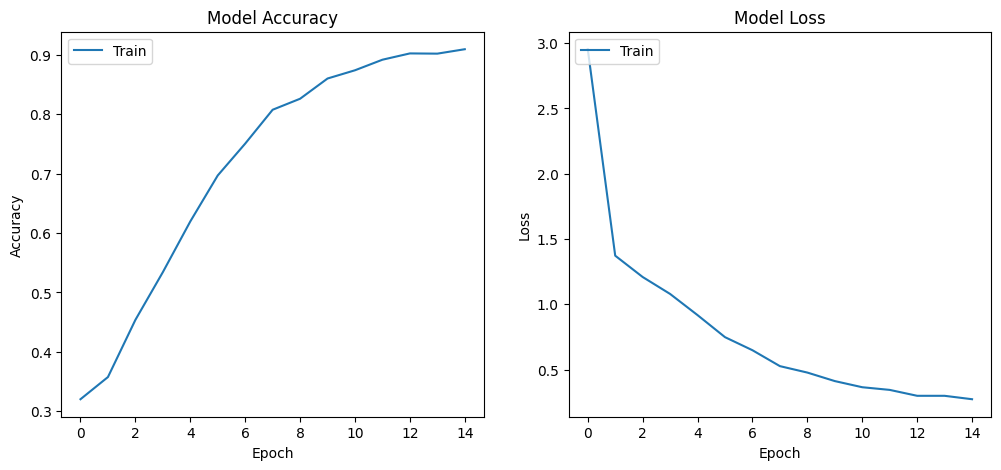

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()


In [17]:
# ----- TRAINING THE CNN MODEL ----- #

model_cnn = build_cnn_model(input_shape=(61, 146), num_classes=4)
X_train_reshaped = X_train.reshape(-1,61,146)
y_train_repeated = np.repeat(y_train, 248, axis=0)
print(X_train_reshaped.shape, y_train_repeated.shape)

history = model_cnn.fit(
    X_train_reshaped, y_train_repeated,
    epochs=6,
    batch_size=8,
)

(7936, 61, 146) (7936, 4)
Epoch 1/6
992/992 [==============================] - 16s 16ms/step - loss: 0.4291 - accuracy: 0.8392
Epoch 2/6
992/992 [==============================] - 16s 16ms/step - loss: 0.0962 - accuracy: 0.9689
Epoch 3/6
992/992 [==============================] - 20s 20ms/step - loss: 0.0893 - accuracy: 0.9727
Epoch 4/6
992/992 [==============================] - 17s 17ms/step - loss: 0.0698 - accuracy: 0.9793
Epoch 5/6
992/992 [==============================] - 17s 17ms/step - loss: 0.0451 - accuracy: 0.9865
Epoch 6/6
992/992 [==============================] - 16s 16ms/step - loss: 0.1131 - accuracy: 0.9720


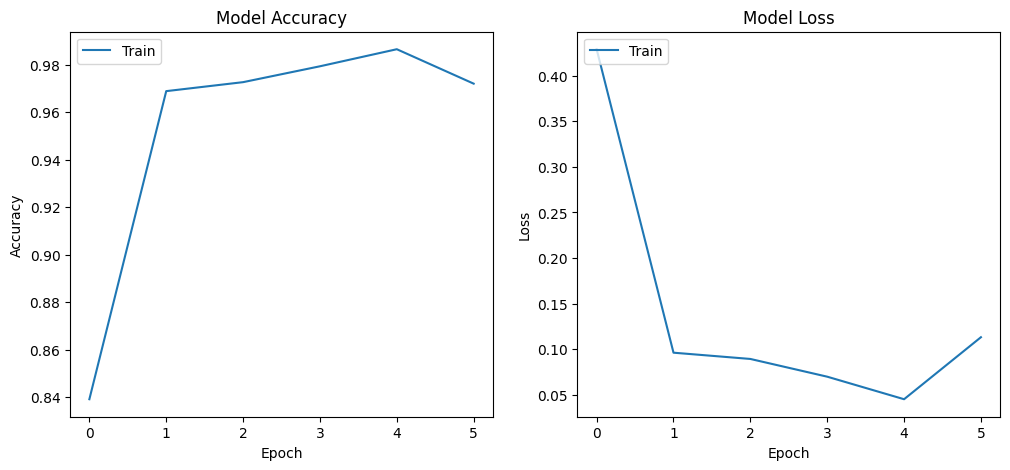

In [18]:
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

In [17]:
############################################################################
# ------------------------------ Test Data ------------------------------ #
############################################################################

In [19]:
# ----- RETRIEVE TEST DATA ----- #

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

print("## Initial shapes of the test data ##")
print(meg_test_data_array.shape)
print(labels_test_array.shape)

## Initial shapes of the test data ##
(8, 248, 35624)
(8,)


In [20]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_test_data_array.shape[0], meg_test_data_array.shape[1], segments, meg_train_data_array.shape[2]//(4*segments)))
print(processed_data.shape)
for i in range(meg_test_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_test_data_array[i], i+1, segments)

(8, 248, 61, 146)
*** FILE 1 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 2 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 3 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 4 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 5 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after segmentation: (248, 61, 146)
*** FILE 6 ***
scaling applied: shape: (248, 35624), lowpass applied: shape: (248, 35624), downsam applied: shape: (248, 8906), Data after seg

In [21]:
X_test = processed_data
y_test = to_categorical(labels_test_array, num_classes=4)

del processed_data, labels_test_array

In [22]:
print("## Data after processing ##")
print("MEG:", X_test.shape)
print("Labels:", y_test.shape)

## Data after processing ##
MEG: (8, 248, 61, 146)
Labels: (8, 4)


In [25]:
# TEST DNN

X_test_dnn = X_test.reshape(-1, 61,146)  # Flatten the test data for DNN
y_test_dnn = np.repeat(y_test, 248, axis=0)
print(X_test_dnn.shape, y_test_dnn.shape)
test_loss_dnn, test_accuracy_dnn = dnn_model.evaluate(X_test_dnn, y_test_dnn)
print("DNN Test Loss:", test_loss_dnn)
print("DNN Test Accuracy:", test_accuracy_dnn)


(1984, 61, 146) (1984, 4)
62/62 [==============================] - 0s 2ms/step - loss: 2.4297 - accuracy: 0.2873
DNN Test Loss: 2.4297025203704834
DNN Test Accuracy: 0.28729838132858276


In [27]:
from sklearn.metrics import confusion_matrix

y_pred = dnn_model.predict(X_test_dnn)

# Convert predictions and true labels to single labels if they are one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_dnn, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

62/62 [==============================] - 0s 2ms/step


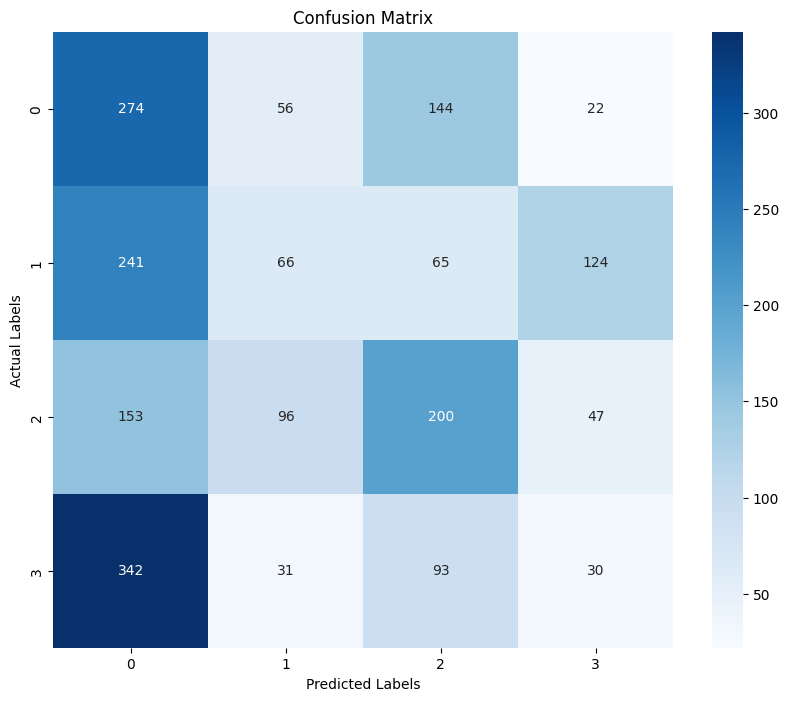

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [43]:
import numpy as np

# Make predictions for the entire test set. They are in one-hot-vector form.
all_predictions = dnn_model.predict(X_test_dnn)

# Convert predictions to class labels (0, 1, 2, 3)
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Aggregate predictions for each original test instance
# For every 248 predictions keep the most frequent one (that represents the each total file's prediction)
final_predictions = []
proportions = []
for i in range(0, len(predicted_labels_all), 248):  # Iterate over each set of 248 sensors (step=248)
    # Get the predictions for the current set of sensors
    sensor_predictions = predicted_labels_all[i:i + 248]
    print(sensor_predictions)

    unique, counts = np.unique(sensor_predictions, return_counts=True)
    print("\n",dict(zip(unique, counts)))

    # Find the most frequent prediction
    most_frequent_prediction = np.argmax(np.bincount(sensor_predictions))
    print("MOST FREQUENT:", most_frequent_prediction)

    # Find the proportion of this prediction compared to all the other labels
    proportion = np.max(np.bincount(sensor_predictions)) / 248
    print(f"PROPORTION: {(proportion*100):.2f}%")
    proportions.append(proportion)

    print("_____________________________________________________________________________________________")
    final_predictions.append(most_frequent_prediction)

62/62 [==============================] - 0s 2ms/step
[2 0 0 0 3 0 0 0 1 1 2 0 1 2 0 1 3 3 3 3 3 3 0 3 3 3 0 3 3 0 0 2 0 2 0 0 0
 0 2 0 1 0 1 0 0 1 1 0 1 2 1 1 3 3 3 3 0 0 3 3 3 2 0 2 3 2 3 3 0 3 2 0 0 0
 0 0 0 0 0 0 0 1 1 1 2 1 2 1 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 3 0 0 0 3 0 1 1
 0 1 0 0 0 0 0 0 1 1 3 1 3 3 3 3 3 3 3 3 3 3 0 3 0 3 3 0 0 1 1 1 0 0 0 0 0
 0 1 0 2 0 2 3 3 3 3 3 3 3 2 3 3 3 3 3 0 3 0 0 2 0 0 0 0 2 2 0 0 1 1 1 1 1
 2 1 3 3 3 3 3 1 0 3 3 3 3 3 3 3 0 3 0 0 2 0 3 1 0 0 0 0 0 0 1 0 2 0 3 1 3
 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 0 0 0 1 0 0 0 0 0]

 {0: 96, 1: 37, 2: 22, 3: 93}
MOST FREQUENT: 0
PROPORTION: 38.71%
_____________________________________________________________________________________________
[0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 1 0 1 0 1 2 2 0 1 0 0 2 0 0
 0 2 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 1 2 1 0 0 2 1 2 3 0 0 1 0 0 0
 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 3 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 1 2 0 0 2 0 0 

In [44]:
print("FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)")
print(final_predictions)
print(list(np.argmax(y_test, axis=1)))
print()
# Calculate accuracy or other metrics if needed
correct_predictions = np.sum(np.array(final_predictions) == np.argmax(y_test, axis=1))
accuracy = correct_predictions / len(final_predictions)
print("Aggregated Accuracy:", accuracy)

FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)
[0, 0, 0, 2, 0, 0, 0, 0]
[1, 3, 2, 2, 1, 0, 3, 0]

Aggregated Accuracy: 0.375


In [29]:
# TEST CNN
X_test_cnn = X_test.reshape(-1, 61,146)  # Reshape the test data for CNN
y_test_cnn = np.repeat(y_test, 248, axis=0)
print(X_test_cnn.shape, y_test_cnn.shape)
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print("CNN Test Loss:", test_loss_cnn)
print("CNN Test Accuracy:", test_accuracy_cnn)


(1984, 61, 146) (1984, 4)
62/62 [==============================] - 1s 13ms/step - loss: 8.6692 - accuracy: 0.2702
CNN Test Loss: 8.669225692749023
CNN Test Accuracy: 0.27016130089759827


In [30]:
from sklearn.metrics import confusion_matrix

y_pred = model_cnn.predict(X_test_cnn)

# Convert predictions and true labels to single labels if they are one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cnn, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

62/62 [==============================] - 1s 13ms/step


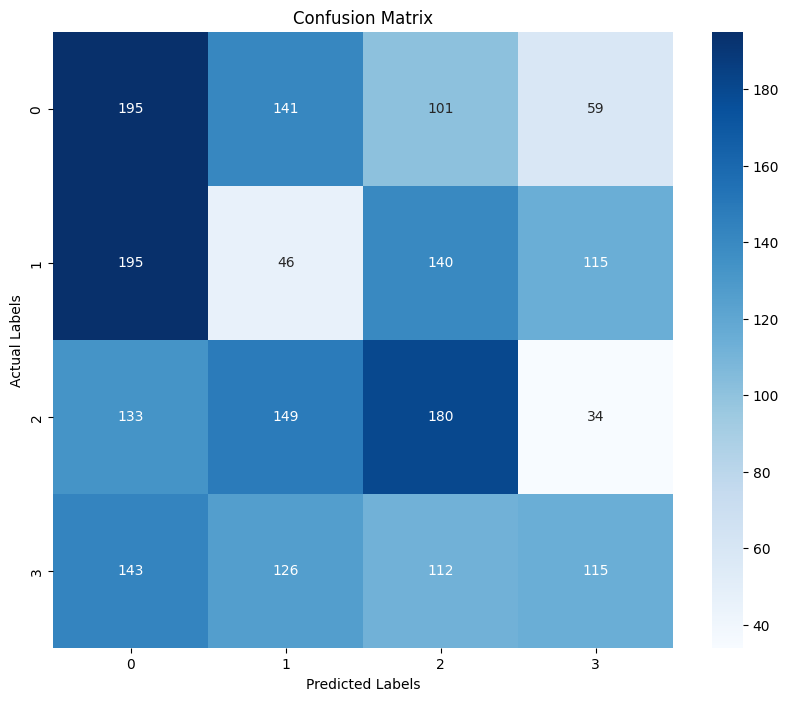

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [33]:
import numpy as np

# Make predictions for the entire test set. They are in one-hot-vector form.
all_predictions = model_cnn.predict(X_test_cnn)

# Convert predictions to class labels (0, 1, 2, 3)
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Aggregate predictions for each original test instance
# For every 248 predictions keep the most frequent one (that represents the each total file's prediction)
final_predictions = []
proportions = []
for i in range(0, len(predicted_labels_all), 248):  # Iterate over each set of 248 sensors (step=248)
    # Get the predictions for the current set of sensors
    sensor_predictions = predicted_labels_all[i:i + 248]
    print(sensor_predictions)

    unique, counts = np.unique(sensor_predictions, return_counts=True)
    print("\n",dict(zip(unique, counts)))

    # Find the most frequent prediction
    most_frequent_prediction = np.argmax(np.bincount(sensor_predictions))
    print("MOST FREQUENT:", most_frequent_prediction)

    # Find the proportion of this prediction compared to all the other labels
    proportion = np.max(np.bincount(sensor_predictions)) / 248
    print(f"PROPORTION: {(proportion*100):.2f}%")
    proportions.append(proportion)

    print("_____________________________________________________________________________________________")
    final_predictions.append(most_frequent_prediction)

62/62 [==============================] - 1s 9ms/step
[2 0 2 1 3 0 2 1 2 2 2 2 2 0 0 2 3 2 1 2 2 2 2 2 2 3 2 3 0 2 3 2 1 1 0 3 0
 2 1 0 2 1 1 0 2 0 2 2 2 1 2 2 3 0 3 3 2 2 3 1 2 1 2 3 3 1 0 2 1 2 2 0 2 1
 0 2 0 0 1 0 1 2 1 2 1 2 2 2 0 3 0 1 2 2 2 2 2 2 3 3 2 2 2 2 0 2 2 2 2 0 2
 0 0 0 0 0 2 2 1 2 2 3 2 0 1 3 3 2 2 2 2 2 0 2 3 2 2 3 2 3 2 2 2 3 1 0 2 0
 2 2 2 1 2 1 3 2 3 3 2 2 3 1 2 3 2 3 3 0 3 0 2 1 2 3 0 1 2 2 0 0 2 2 2 2 2
 1 2 1 3 3 3 3 2 1 2 2 2 3 2 2 2 2 2 2 0 1 0 1 2 3 0 2 0 2 2 2 2 0 2 3 2 0
 0 2 0 3 2 2 2 2 3 3 2 2 2 2 1 0 3 3 2 0 2 0 3 1 0 0]

 {0: 48, 1: 34, 2: 122, 3: 44}
MOST FREQUENT: 2
PROPORTION: 49.19%
_____________________________________________________________________________________________
[0 1 2 2 2 0 2 3 0 0 0 0 0 3 0 0 2 0 2 0 1 2 1 2 1 2 2 2 2 3 2 3 1 2 2 1 0
 0 3 3 2 3 3 0 0 2 0 0 0 3 0 0 2 0 1 0 1 1 2 3 2 2 1 2 3 3 2 2 1 2 3 1 0 3
 0 0 0 0 3 0 0 0 0 0 3 0 0 3 2 1 2 0 0 2 0 1 2 2 2 2 3 2 2 2 2 1 1 2 3 0 0
 0 2 0 0 0 0 0 0 0 0 2 0 2 2 2 2 1 1 1 2 2 2 3 2 2 2 2 3

In [41]:
print("FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)")
print(final_predictions)
print(list(np.argmax(y_test, axis=1)))
print()
# Calculate accuracy or other metrics if needed
correct_predictions = np.sum(np.array(final_predictions) == np.argmax(y_test, axis=1))
accuracy = correct_predictions / len(final_predictions)
print("Aggregated Accuracy:", accuracy)

FINAL PREDICTIONS (TOP), ACTUAL LABELS (BOTTOM)
[2, 0, 2, 0, 0, 0, 1, 0]
[1, 3, 2, 2, 1, 0, 3, 0]

Aggregated Accuracy: 0.375


In [28]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 246, 128)          3420032   
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          98560     
                                                                 
 flatten_1 (Flatten)         (None, 62464)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               15991040  
                                                                 
 dense_4 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 19510660 (74.43 MB)
Trainable params: 19510660 (74.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


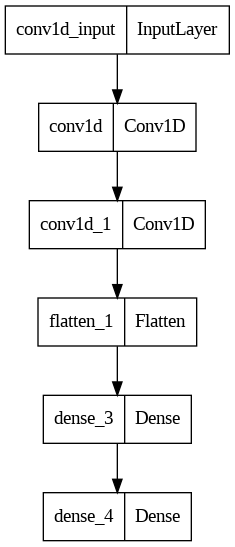

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model_cnn)

In [ ]:
'''
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 conv1d_9 (Conv1D)           (None, 246, 64)           93760

 max_pooling1d_8 (MaxPoolin  (None, 123, 64)           0
 g1D)

 conv1d_10 (Conv1D)          (None, 121, 128)          24704

 max_pooling1d_9 (MaxPoolin  (None, 60, 128)           0
 g1D)

 flatten_9 (Flatten)         (None, 7680)              0

 dense_23 (Dense)            (None, 128)               983168

 dense_24 (Dense)            (None, 4)                 516

=================================================================
Total params: 1102148 (4.20 MB)
Trainable params: 1102148 (4.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


CNN Test Loss: 1.647630214691162
CNN Test Accuracy: 0.625
'''

In [31]:
#---------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------